[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\eders\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\eders\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\eders\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\eders\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\eders\AppData\Roaming\nltk_data...
[

Total de palavras antes do balanceamento:
Real: 2222405, Fake: 382623

Total de palavras após o balanceamento:
Real: 382507
Fake: 382623
Acurácia do modelo: 86.89%
Palavras: 22185, bigramas: 454868, Trigramas: 680067
   * Um total de 1157121 tokens foram computadas a partir do conjunto de dados.



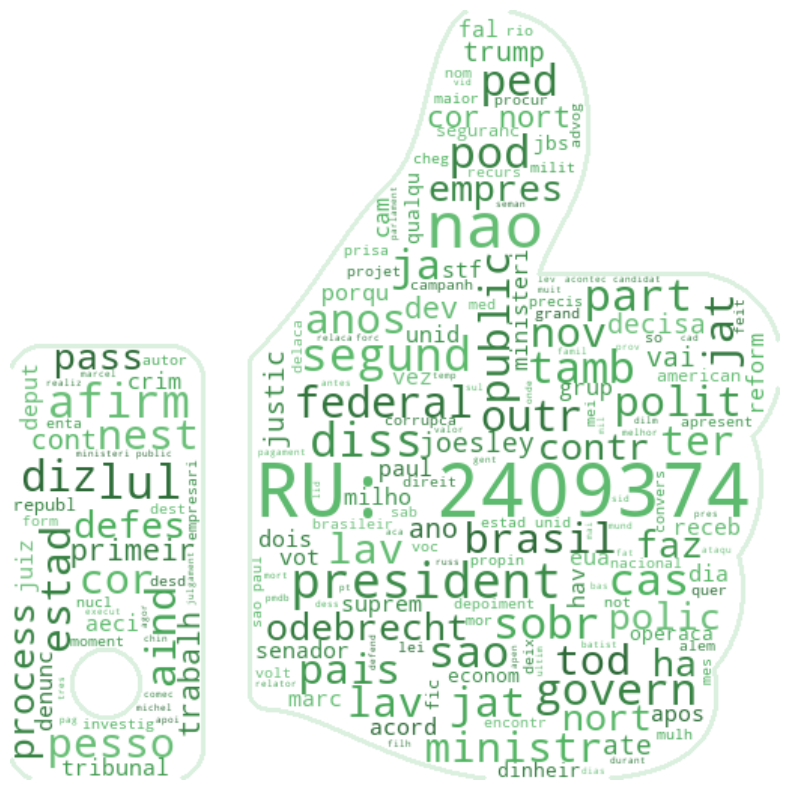

Palavras: 22185, bigramas: 454868, Trigramas: 680067
   * Um total de 1157121 tokens foram computadas a partir do conjunto de dados.



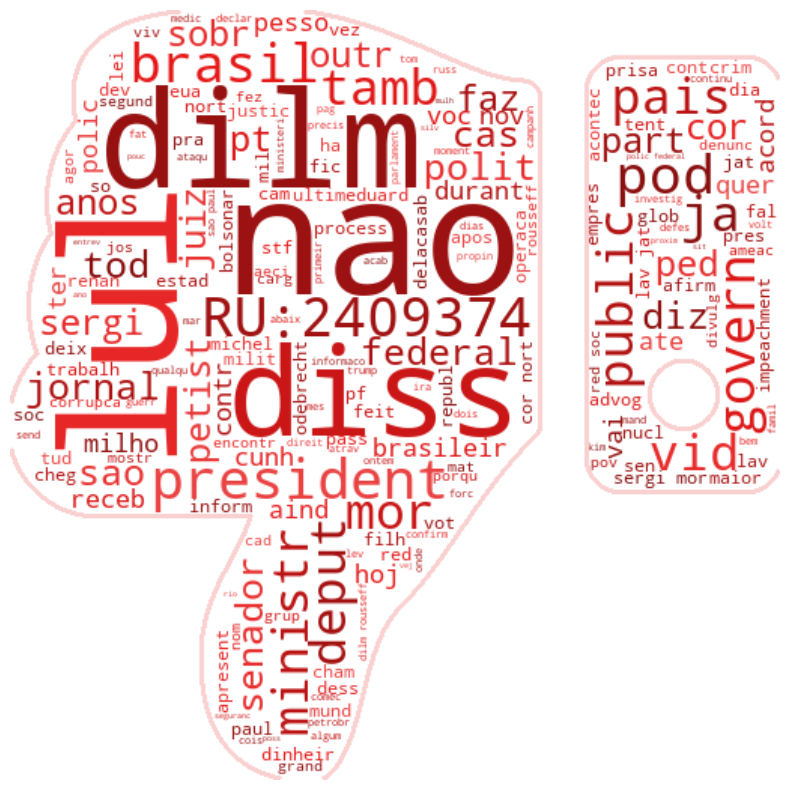

(<wordcloud.wordcloud.WordCloud at 0x187a43c3cb0>, 1157121)

In [ ]:
import pandas as pd
import numpy as np
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

from funcoes_auxiliares import gerar_nuvem_palavras

nltk.download("all")

# Cria o dataframe
df = pd.read_csv('pre-processed.csv')

stemmer = SnowballStemmer("portuguese")
stop_words = set(stopwords.words('portuguese'))

# 1. PROCEDIMENTOS DE LIMPEZA
def limpeza_texto(texto):
    #Tokenização
    tokens = word_tokenize(texto, language="portuguese")
    #Retirar acentos e números; deixar em minúsculas e apenas com o radical(STEM)
    tokens = [stemmer.stem(token.lower()) for token in tokens if token.isalpha()]
    #Retirar stopwords e pontuações
    tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation]
    return ' '.join(tokens)

# Limpeza no dataframe com a função acima
df['preprocessed_news'] = df['preprocessed_news'].apply(limpeza_texto)

# 1. Conta palavras por notícia
df['word_count'] = df['preprocessed_news'].str.split().str.len()

# 2. Separa os grupos
real_news = df[df['label'] == 'true'].copy()
fake_news = df[df['label'] == 'fake'].copy()

# 3. Soma total de palavras por grupo
total_real = real_news['word_count'].sum()
total_fake = fake_news['word_count'].sum()

print("Total de palavras antes do balanceamento:")
print(f"Real: {total_real}, Fake: {total_fake}")

# 4. Define o limite (mínimo total de palavras entre os grupos)
limite_palavras = min(total_real, total_fake)

# 5. Função para truncar um grupo até atingir o limite de palavras
def truncar_por_palavras(df, limite):
    acumulado = 0
    indices = []
    for i, qtd in zip(df.index, df['word_count']):
        if acumulado + qtd > limite:
            break
        acumulado += qtd
        indices.append(i)
    return df.loc[indices]

# 6. Aplica truncamento
real_truncado = truncar_por_palavras(real_news, limite_palavras)
fake_truncado = truncar_por_palavras(fake_news, limite_palavras)

# 7. Junta os dois grupos balanceados
df_truncado = pd.concat([real_truncado, fake_truncado]).reset_index(drop=True)

# 8. Verificação
print("\nTotal de palavras após o balanceamento:")
print("Real:", df_truncado[df_truncado['label']=='true']['word_count'].sum())
print("Fake:", df_truncado[df_truncado['label']=='fake']['word_count'].sum())

# Remonta as notícias em string e cria a coluna no dataframe para o resultado desta limpeza
df_truncado['clean_news'] = df_truncado['preprocessed_news']

# Matriz de frequências TF-IDF (n-gramas de 1 a 3)
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X = vectorizer.fit_transform(df_truncado['clean_news'])
y = df_truncado['label']

# Split: 75% para treino e 25% para teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# 3. Regressão logística
logreg_model = LogisticRegression(solver='lbfgs', max_iter=1000) 
logreg_model.fit(X_train, y_train)

# Predição dos textos
proba_predictions = logreg_model.predict_proba(X_test)
predicted_labels = logreg_model.predict(X_test)

# Acurácia
accuracy = accuracy_score(y_test, predicted_labels)
print(f'Acurácia do modelo: {accuracy:.2%}')

# Frequências do treinamento
frequencias_treinamento = dict(zip(vectorizer.get_feature_names_out(), X_train.sum(axis=0).A1))

# Seleção de índices das notícias verdadeiras
real_mask = df_truncado['label'] == 'true'
indices_real = np.where(real_mask.to_numpy())[0]
X_real = X[indices_real]

# Frequências para textos verdadeiros. Convertendo os conjuntos para dicionários
frequencias_real = dict(zip(vectorizer.get_feature_names_out(), X_real.sum(axis=0).A1))

# Contagem de palavras, bigramas e trigramas
num_palavras_real = sum(1 for token in frequencias_real if ' ' not in token)
num_bigramas_real = sum(1 for token in frequencias_real if token.count(' ') == 1)
num_trigramas_real = sum(1 for token in frequencias_real if token.count(' ') == 2)

print(f'Palavras: {num_palavras_real}, bigramas: {num_bigramas_real}, Trigramas: {num_trigramas_real}')

frequencias_real["RU: 2409374"]= 30

# Gera nuvem de palavras - textos verdadeiros
gerar_nuvem_palavras(
    arquivo_mascara="thumbs_up_mask.png",
    dicionario_tokens_e_frequencia=frequencias_real)

# Seleção de índices das notícias falsas
fake_mask = df_truncado['label'] == 'fake'
indices_fake = np.where(fake_mask.to_numpy())[0]
X_fake = X[indices_fake]

# Frequências para textos falsos. Convertendo os conjuntos para dicionários
frequencias_falsas = dict(zip(vectorizer.get_feature_names_out(), X_fake.sum(axis=0).A1))

# Contagem de palavras, bigramas e trigramas - textos falsos
num_palavras_fake = sum(1 for token in frequencias_falsas if ' ' not in token)
num_bigramas_fake = sum(1 for token in frequencias_falsas if token.count(' ') == 1)
num_trigramas_fake = sum(1 for token in frequencias_falsas if token.count(' ') == 2)

print(f'Palavras: {num_palavras_fake}, bigramas: {num_bigramas_fake}, Trigramas: {num_trigramas_fake}')

frequencias_falsas["RU:2409374"]= 30

# Gera nuvem de palavras - textos falsos
gerar_nuvem_palavras(
    arquivo_mascara="thumbs_down_mask.png",
    dicionario_tokens_e_frequencia=frequencias_falsas)
